# Raport - Nazwa_Zespołu_1

# 1. Model from "A Learning-Based Model to Evaluate Hospitalization Priority in COVID-19 Pandemics" article

In [264]:
import pandas as pd
import math
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn import preprocessing
from sklearn.pipeline import Pipeline
from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score, accuracy_score, roc_auc_score
import xgboost as xgb
import seaborn as sns
import warnings
import pickle
import json
from functools import partial
warnings.filterwarnings("ignore")

In [265]:
df_usa = pd.read_csv('Yan_reply_First_last_wtime.csv')
df_france = pd.read_excel('french.xlsx')
df_china = pd.read_excel('time_series_375_prerpocess_en.xlsx', index_col=[0,1])
df_china = df_china.groupby('PATIENT_ID').last()

df_new = pd.read_csv('dataset.csv')
dictio = {True:1, False:0}
df_new['outcome'] = df_new['Degree_Severe'].map(dictio)

## 1.1 Variables distributions

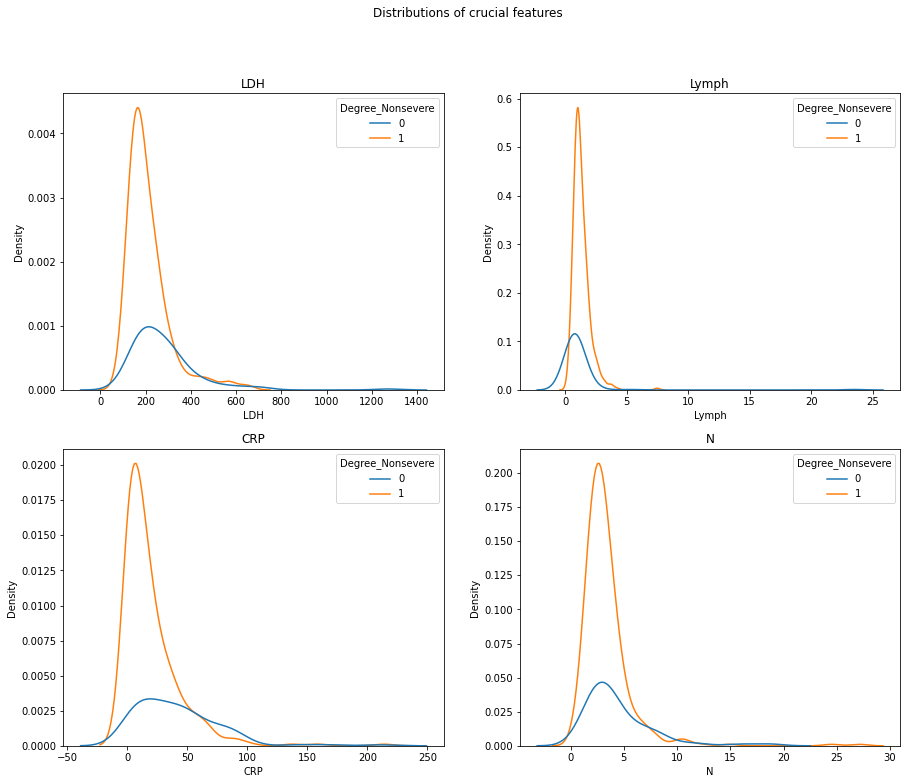

In [266]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))

sns.kdeplot(data = df_new, x="Laboratory_test_LDH_(U/L)", hue="Degree_Nonsevere", ax = ax1)
ax1.set_title("LDH")
ax1.set_xlabel('LDH')
#ax1.set_xlim([0, 1300])

sns.kdeplot(data = df_new, x="Laboratory_test_L", hue="Degree_Nonsevere", ax = ax2)
ax2.set_title("Lymph")
ax2.set_xlabel('Lymph')
#ax2.set_xlim([0, 1300])

sns.kdeplot(data = df_new, x="Laboratory_test_CRP_(mg/L)", hue="Degree_Nonsevere", ax = ax3)
ax3.set_title("CRP")
ax3.set_xlabel('CRP')
#ax3.set_xlim([0, 1300])

sns.kdeplot(data = df_new, x="Laboratory_test_N", hue="Degree_Nonsevere", ax = ax4)
ax4.set_title("N")
ax4.set_xlabel('N')
#ax4.set_xlim([0, 1300])

plt.suptitle('Distributions of crucial features')
plt.show()

In [23]:
df_new['lymph'] = df_new['Laboratory_test_L'] * 10
def draw_plot(df1, main_feature1, div_feature1, title1,
              df2, main_feature2, div_feature2, title2,
              df3, main_feature3, div_feature3, title3,
              feature_name, title, lim):
    
    fig, ax = plt.subplots(2, 3, figsize=(20, 8))
    fig.suptitle(title)

    sns.stripplot(x=main_feature1, y=df1[div_feature1].astype(str),
                  data=df1, dodge=True, alpha=.4, zorder=1, palette=["g", "m"], ax=ax[0][0], order=["0", "1"])
    ax[0][0].set_title(title1)
    ax[0][0].set(xlim=(0, lim))
    ax[0][0].set(xlabel="")
    ax[0][0].set(ylabel="Survival/death")
    ax[0][0].set_yticklabels(["Alive", "Deceased"])

    sns.stripplot(x=main_feature2, y=df2[div_feature2].astype(str),
                  data=df2, dodge=True, alpha=.4, zorder=1, palette=["g", "m"], ax=ax[0][1], order=["0", "1"])
    ax[0][1].set_title(title2)
    ax[0][1].set(xlim=(0, lim))
    ax[0][1].set(ylabel="")
    ax[0][1].set_yticklabels(["Alive", "Deceased"])
    ax[0][1].set(xlabel="")

    sns.stripplot(x=main_feature3, y=df3[div_feature3].astype(str),
                  data=df3, dodge=True, alpha=.4, zorder=1, palette=["g", "m"], ax=ax[0][2], order=["0", "1"])
    ax[0][2].set_title(title3)
    ax[0][2].set(xlim=(0, lim))
    ax[0][2].set(ylabel="")
    ax[0][2].set_yticklabels(["Alive", "Deceased"])
    ax[0][2].set(xlabel="")

    sns.boxplot(y=df1[div_feature1].astype(str), x=main_feature1, data=df1, ax=ax[1][0], palette=["g", "m"], linewidth=1, fliersize=3, order=["0", "1"])
    ax[1][0].set(xlim=(0, lim))
    ax[1][0].set(xlabel=feature_name)
    ax[1][0].set(ylabel="Survival/death")
    ax[1][0].set_yticklabels(["Alive", "Deceased"])

    sns.boxplot(y=df2[div_feature2].astype(str), x=main_feature2, data=df2, ax=ax[1][1], palette=["g", "m"],linewidth=1, fliersize=3, order=["0", "1"])
    ax[1][1].set(xlim=(0, lim))
    ax[1][1].set(xlabel=feature_name)
    ax[1][1].set(ylabel="")
    ax[1][1].set_yticklabels(["Alive", "Deceased"])

    sns.boxplot(y=df3[div_feature3].astype(str), x=main_feature3, data=df3, ax=ax[1][2], palette=["g", "m"],linewidth=1, fliersize=3, order=["0", "1"])
    ax[1][2].set(xlim=(0, lim))
    ax[1][2].set(xlabel=feature_name)
    ax[1][2].set(ylabel="")
    ax[1][2].set_yticklabels(["Alive", "Deceased"])

    plt.subplots_adjust(wspace=0.35, hspace=0.35, top=0.85)

    sns.despine()
    #fig.savefig('ldh_usa.png', dpi=fig.dpi)
    plt.show()

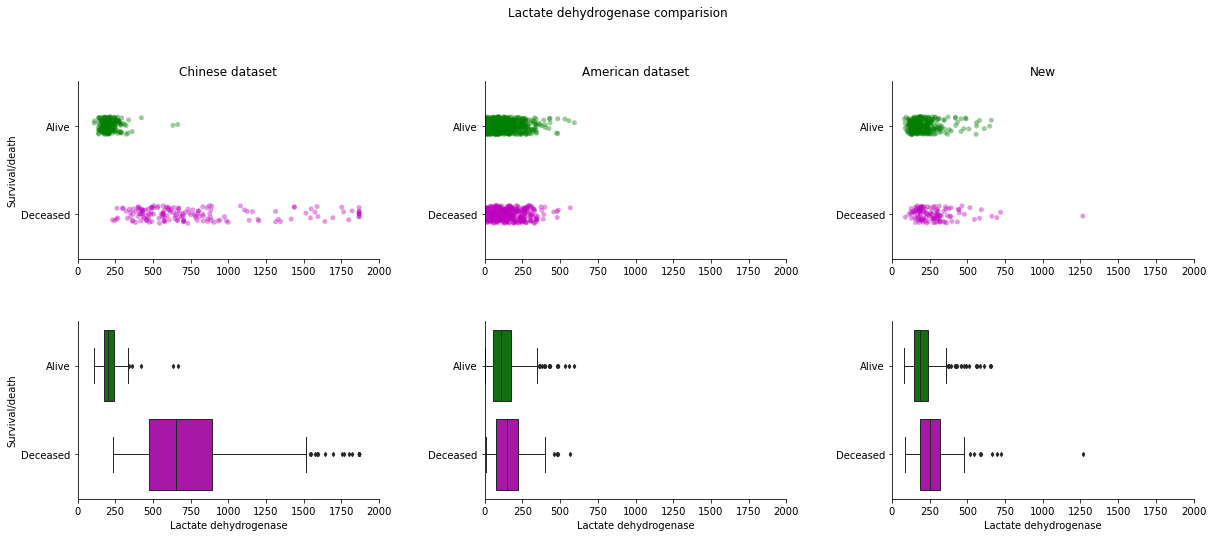

In [24]:
draw_plot(df_china, 'Lactate dehydrogenase', 'outcome', 'Chinese dataset',
          df_usa, 'First_CRP', 'Expired_Outcome', 'American dataset',
          df_new, 'Laboratory_test_LDH_(U/L)', 'outcome', 'New',
          'Lactate dehydrogenase', 'Lactate dehydrogenase comparision', 2000)

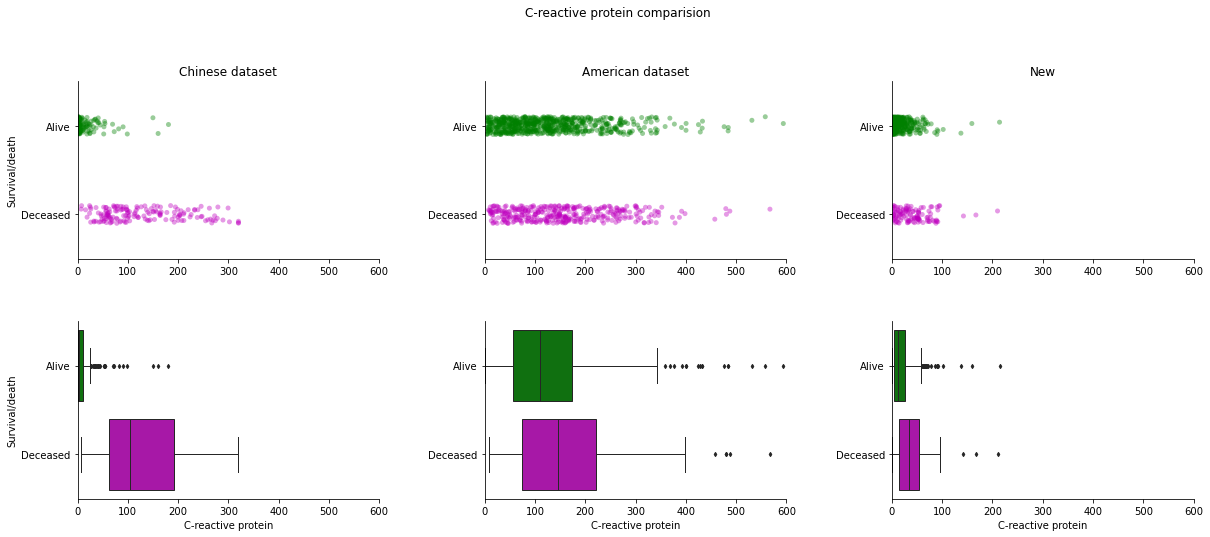

In [25]:
draw_plot(df_china, 'High sensitivity C-reactive protein', 'outcome', 'Chinese dataset',
          df_usa, 'First_CRP', 'Expired_Outcome', 'American dataset',
          df_new, 'Laboratory_test_CRP_(mg/L)', 'outcome', 'New',
          'C-reactive protein', 'C-reactive protein comparision', 600)

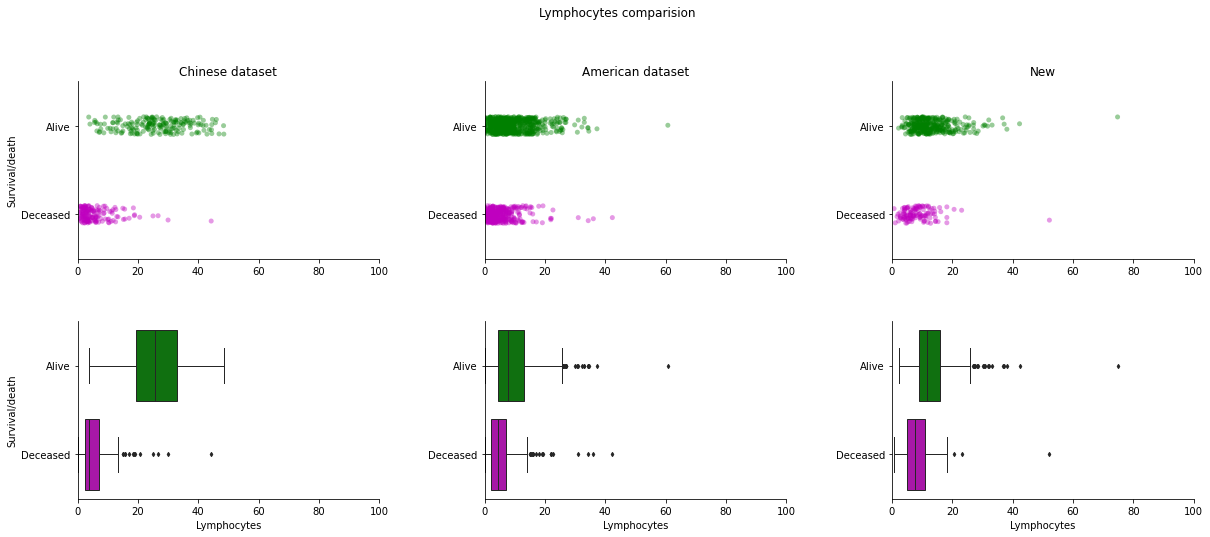

In [26]:
draw_plot(df_china, '(%)lymphocyte', 'outcome', 'Chinese dataset',
          df_usa, 'First_Lymph', 'Expired_Outcome', 'American dataset',
          df_new, 'lymph', 'outcome', 'New',
          'Lymphocytes', 'Lymphocytes comparision', 100)

[Text(0, 0, 'Alive'), Text(0, 1, 'Deceased')]

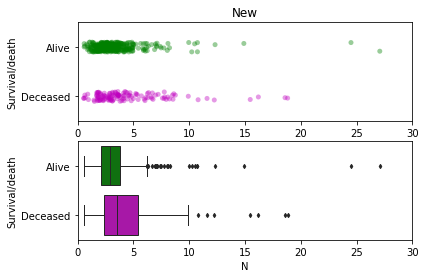

In [27]:
fig, ax = plt.subplots(2, figsize=(6, 4))

sns.stripplot(x='Laboratory_test_N', y=df_new['outcome'].astype(str),
                  data=df_new, dodge=True, alpha=.4, zorder=1, palette=["g", "m"], ax=ax[0], order=["0", "1"])
ax[0].set_title('New')
ax[0].set(xlim=(0, 30))
ax[0].set(xlabel="")
ax[0].set(ylabel="Survival/death")
ax[0].set_yticklabels(["Alive", "Deceased"])
    
sns.boxplot(y=df_new['outcome'].astype(str), x='Laboratory_test_N', data=df_new, ax=ax[1], palette=["g", "m"], linewidth=1, fliersize=3, order=["0", "1"])
ax[1].set(xlim=(0, 30))
ax[1].set(xlabel='N')
ax[1].set(ylabel="Survival/death")
ax[1].set_yticklabels(["Alive", "Deceased"])

## 1.2 Model validation on the dataset from the article

In [35]:
# Function for model score print
def model_metrics(Y, Y_pred):
    
    Metrics = []
    Metrics.append(accuracy_score(Y, Y_pred))
    Metrics.append(recall_score(Y, Y_pred))
    Metrics.append(precision_score(Y, Y_pred))
    Metrics.append(f1_score(Y, Y_pred))
    Metrics.append(roc_auc_score(Y, Y_pred))
    
    print("Confusion Matrix:")
    print(confusion_matrix(Y, Y_pred))
    print("###################")
    print("Accuracy: ", Metrics[0])
    print("Recall: ", Metrics[1])
    print("Precision: ", Metrics[2])
    print("F1: ", Metrics[3])
    print("ROC-AUC: ", Metrics[4])
    
    return Metrics

In [36]:
data = pd.read_csv('data_processed.csv')

In [37]:
dictio = {True:1, False:0}
data['any_Underlying']=data['any_Underlying'].map(dictio)
data['any_Symptoms']=data['any_Symptoms'].map(dictio)
data['Degree_Severe']=data['Degree_Severe'].map(dictio)
data['Laboratory_test_L'] = data['Laboratory_test_L'] * 10
data.head()

,Interval,Age,Laboratory_test_WBC,Laboratory_test_L,Laboratory_test_N,Laboratory_test_CRP_(mg/L),Laboratory_test_D_dimer_(ug/ml),Laboratory_test_ALT_(U/L),Laboratory_test_AST_(U/L),Laboratory_test_TB_(umol/L),...,Symptoms_Fever,Symptoms_Cough,Symptoms_Dyspnea,Symptoms_Fatigue,Symptoms_Nausea/Emesis,Symptoms_Myalgia,Symptoms_Dizziness/Headache,any_Underlying,any_Symptoms,Degree_Severe
0,9.0,30.0,3.32,9.1,1.77,0.785,1.12,16.8,28.2,4.94,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0,1,0
1,27.0,54.0,2.58,3.4,1.94,16.300,0.27,19.0,26.9,11.03,...,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0,1,0
2,6.0,29.0,6.79,22.5,4.10,4.750,0.37,25.1,23.4,24.80,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0,1,0
3,8.0,84.0,19.64,3.7,18.59,6.530,0.63,21.0,38.0,9.89,...,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1,1,1
4,31.0,43.0,3.02,6.8,2.08,32.700,0.16,15.3,24.5,14.82,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0,1,0


### 1.2.1 Model on age, ldh, crp and limph

In [240]:
import xgboost as xgb
from xgboost import XGBClassifier

X = data[['Age', 'Laboratory_test_L', 'Laboratory_test_CRP_(mg/L)', 'Laboratory_test_LDH_(U/L)']]
X.columns = ['age', 'lymph', 'crp', 'ldh']
Y = data['Degree_Severe']
X_train, X_test, Y_train , Y_test = train_test_split(X, Y, stratify = Y, test_size = 0.3, random_state = 42)

In [244]:
params =  {'max_depth': 8, 'alpha': 4.0, 'colsample_bytree': 0.9, 'eta': 0.25, 'gamma': 1, 'lambda': 2,
                              'min_child_weight': 7.0, 'scale_pos_weight': 20.0,
                             'subsample': 0.9,
                             'n_estimators': 120,"random_state":42}

model_xgb = XGBClassifier(**params, eval_metric = "error")

model_xgb.fit(X_train, Y_train)
y_pred = model_xgb.predict(X_test)
y_prob = model_xgb.predict_proba(X_test)
score1 = xgb_score = model_metrics(Y_test, y_pred)

Confusion Matrix:
[[42 10]
 [ 0 13]]
###################
Accuracy:  0.8461538461538461
Recall:  1.0
Precision:  0.5652173913043478
F1:  0.7222222222222222
ROC-AUC:  0.9038461538461539


### 1.2.2 Model on ldh, crp, limph and n

In [242]:
X2 = data[['Laboratory_test_N', 'Laboratory_test_L', 'Laboratory_test_CRP_(mg/L)', 'Laboratory_test_LDH_(U/L)']]
X_train2, X_test2, Y_train2 , Y_test2 = train_test_split(X2, Y, stratify = Y, test_size = 0.3, random_state = 42)

model_xgb2 = XGBClassifier(**params, eval_metric = "logloss")

model_xgb2.fit(X_train2, Y_train2)
y_pred2 = model_xgb2.predict(X_test2)
y_prob2 = model_xgb2.predict_proba(X_test2)
score2 = model_metrics(Y_test2, y_pred2)

Confusion Matrix:
[[41 11]
 [ 1 12]]
###################
Accuracy:  0.8153846153846154
Recall:  0.9230769230769231
Precision:  0.5217391304347826
F1:  0.6666666666666667
ROC-AUC:  0.8557692307692308


### 1.2.3 Summary

In [245]:
merged_results1 = pd.DataFrame([np.around(score1, 3), np.around(score2, 3)], columns= ["Accuracy", "Recall", "Precision", "F1-score", "ROC-AUC"])
merged_results1["Model"] = ["XGBoost with Age", "XGBoost with N"]

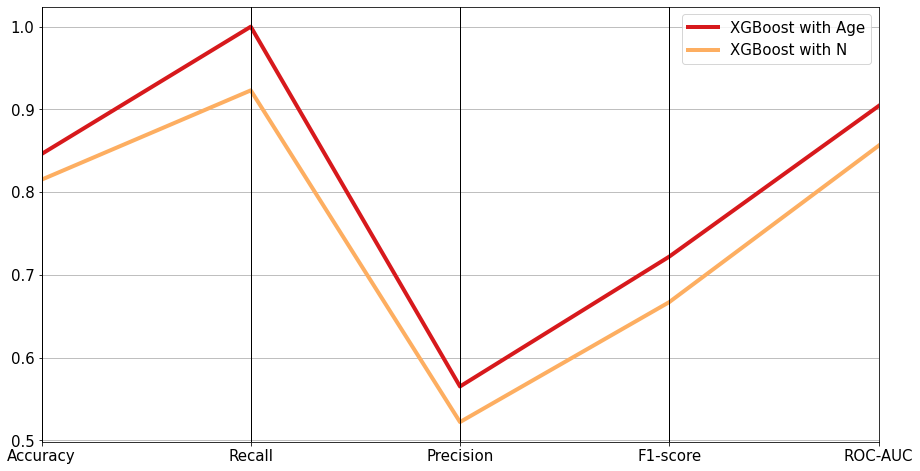

In [247]:
fig, ax = plt.subplots(figsize = (15, 8))
ax = pd.plotting.parallel_coordinates(merged_results1, 'Model', color=('#d7191c', '#fdae61', '#abdda4','#2b83ba'), linewidth = 4)
plt.legend(fontsize = 15)
ax.tick_params(axis = "both", which = "major", labelsize = 15)
#plt.savefig("merged_parallel.png")
plt.show()

## 1.3 Model validation on the supplementary dataset (from the first article)

### 1.3.1 Model on age, ldh, crp and limph

In [268]:
china_new = pd.read_csv('china_processed.csv') 

In [269]:
X_china = china_new[['age', 'First_Lymph', 'First_CRP', 'First_LDH']]
X_china.columns = ['age', 'lymph', 'crp', 'ldh']
Y_china = china_new['outcome']

In [270]:
y_china_pred = model_xgb.predict(X_china)
y_china_prob = model_xgb.predict_proba(X_china)
score3 = model_metrics(y_china_pred, Y_china)

Confusion Matrix:
[[107   4]
 [ 85 155]]
###################
Accuracy:  0.7464387464387464
Recall:  0.6458333333333334
Precision:  0.9748427672955975
F1:  0.7769423558897243
ROC-AUC:  0.8048986486486487


### 1.3.2 Model on ldh, crp, limph and n

In [47]:
china_new_n = pd.read_csv('china_processed_n.csv') #przetworzone chińskie dane

In [271]:
X_china_n = china_new_n[['neutrophil', 'lymphocyte', 'c_protein', 'lactate']]
X_china_n.columns = ['Laboratory_test_N', 'Laboratory_test_L', 'Laboratory_test_CRP_(mg/L)',
                    'Laboratory_test_LDH_(U/L)']
Y_china_n = china_new_n['outcome']

In [272]:
y_china_pred_n = model_xgb2.predict(X_china_n)
y_china_prob_n = model_xgb2.predict_proba(X_china_n)
score4 = model_metrics(y_china_pred_n, Y_china_n)

Confusion Matrix:
[[ 43   1]
 [149 158]]
###################
Accuracy:  0.5726495726495726
Recall:  0.5146579804560261
Precision:  0.9937106918238994
F1:  0.6781115879828327
ROC-AUC:  0.7459653538643767


### 1.3.3 Summary

In [250]:
merged_results2 = pd.DataFrame([np.around(score3, 3), np.around(score4, 3)], columns= ["Accuracy", "Recall", "Precision", "F1-score", "ROC-AUC"])
merged_results2["Model"] = ["XGBoost with Age", "XGBoost with N"]

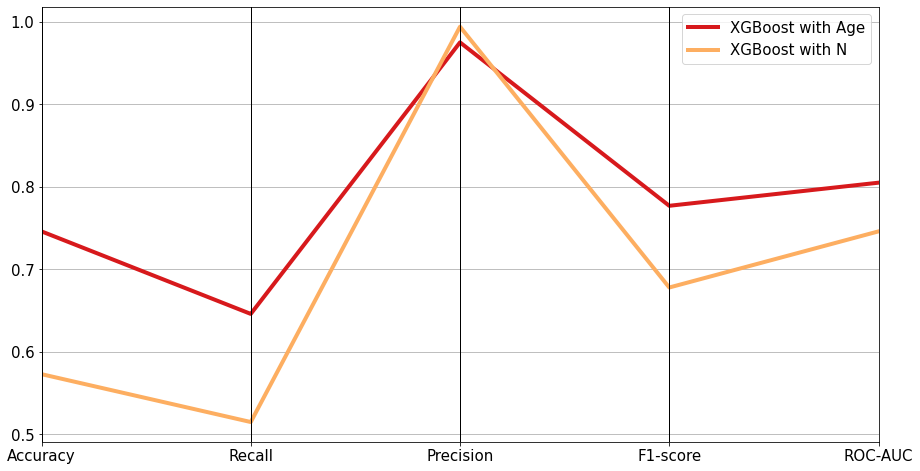

In [251]:
fig, ax = plt.subplots(figsize = (15, 8))
ax = pd.plotting.parallel_coordinates(merged_results2, 'Model', color=('#d7191c', '#fdae61', '#abdda4','#2b83ba'), linewidth = 4)
plt.legend(fontsize = 15)
ax.tick_params(axis = "both", which = "major", labelsize = 15)
#plt.savefig("merged_parallel.png")
plt.show()

## 1.4 Tabnet model on the dataset from the article

### 1.4.1 Model on age, ldh, crp and limph

In [273]:
from pytorch_tabnet.tab_model import TabNetClassifier


X_train_t, X_train_v, Y_train_t , Y_train_v = train_test_split(X_train, Y_train, stratify = Y_train, test_size = 0.2, random_state = 42)
clf_tab = TabNetClassifier(seed = 123)
clf_tab.fit(X_train_t.to_numpy(), Y_train_t.to_numpy(), eval_set = [(X_train_v.to_numpy(), Y_train_v.to_numpy())])
tab_preds = clf_tab.predict(X_test.to_numpy())

Device used : cpu
epoch 0  | loss: 1.06266 | val_0_auc: 0.5     |  0:00:00s
epoch 1  | loss: 0.73388 | val_0_auc: 0.54167 |  0:00:00s
epoch 2  | loss: 0.48669 | val_0_auc: 0.46528 |  0:00:00s
epoch 3  | loss: 0.43912 | val_0_auc: 0.61111 |  0:00:00s
epoch 4  | loss: 0.39141 | val_0_auc: 0.65278 |  0:00:00s
epoch 5  | loss: 0.35948 | val_0_auc: 0.70139 |  0:00:00s
epoch 6  | loss: 0.33884 | val_0_auc: 0.6875  |  0:00:00s
epoch 7  | loss: 0.31553 | val_0_auc: 0.68056 |  0:00:00s
epoch 8  | loss: 0.29685 | val_0_auc: 0.63889 |  0:00:00s
epoch 9  | loss: 0.28192 | val_0_auc: 0.66667 |  0:00:00s
epoch 10 | loss: 0.27347 | val_0_auc: 0.66667 |  0:00:00s
epoch 11 | loss: 0.27031 | val_0_auc: 0.59028 |  0:00:00s
epoch 12 | loss: 0.25849 | val_0_auc: 0.65972 |  0:00:00s
epoch 13 | loss: 0.24969 | val_0_auc: 0.55556 |  0:00:00s
epoch 14 | loss: 0.24164 | val_0_auc: 0.57639 |  0:00:00s
epoch 15 | loss: 0.23335 | val_0_auc: 0.5625  |  0:00:00s

Early stopping occurred at epoch 15 with best_epoch =

In [274]:
tab_score_merged = model_metrics(Y_test.to_numpy(), tab_preds)

Confusion Matrix:
[[43  9]
 [ 2 11]]
###################
Accuracy:  0.8307692307692308
Recall:  0.8461538461538461
Precision:  0.55
F1:  0.6666666666666667
ROC-AUC:  0.8365384615384616


### 1.4.2 Model on ldh, crp, limph and n

In [224]:
X_train2_t, X_train2_v, Y_train2_t , Y_train2_v = train_test_split(X_train2, Y_train2, stratify = Y_train2, test_size = 0.5, random_state = 42)

clf_tab2 = TabNetClassifier(seed = 123)
clf_tab2.fit(X_train2_t.to_numpy(), Y_train2_t.to_numpy(), eval_set = [(X_train2_v.to_numpy(), Y_train2_v.to_numpy())])
tab_preds = clf_tab2.predict(X_test2.to_numpy())

Device used : cpu
epoch 0  | loss: 1.15332 | val_0_auc: 0.51667 |  0:00:00s
epoch 1  | loss: 0.78208 | val_0_auc: 0.51333 |  0:00:00s
epoch 2  | loss: 0.52047 | val_0_auc: 0.51222 |  0:00:00s
epoch 3  | loss: 0.45045 | val_0_auc: 0.52778 |  0:00:00s
epoch 4  | loss: 0.38052 | val_0_auc: 0.56111 |  0:00:00s
epoch 5  | loss: 0.33644 | val_0_auc: 0.56889 |  0:00:00s
epoch 6  | loss: 0.32647 | val_0_auc: 0.55222 |  0:00:00s
epoch 7  | loss: 0.33966 | val_0_auc: 0.57111 |  0:00:00s
epoch 8  | loss: 0.32661 | val_0_auc: 0.59111 |  0:00:00s
epoch 9  | loss: 0.26867 | val_0_auc: 0.56    |  0:00:00s
epoch 10 | loss: 0.2456  | val_0_auc: 0.56111 |  0:00:00s
epoch 11 | loss: 0.33694 | val_0_auc: 0.54556 |  0:00:00s
epoch 12 | loss: 0.29995 | val_0_auc: 0.58333 |  0:00:00s
epoch 13 | loss: 0.3072  | val_0_auc: 0.66    |  0:00:00s
epoch 14 | loss: 0.28297 | val_0_auc: 0.60889 |  0:00:00s
epoch 15 | loss: 0.27877 | val_0_auc: 0.61778 |  0:00:00s
epoch 16 | loss: 0.24053 | val_0_auc: 0.60889 |  0:00:

In [226]:
tab_preds2= clf_tab2.predict(X_test2.to_numpy())

tab_score_merged2 = model_metrics(Y_test2.to_numpy(), tab_preds2)

Confusion Matrix:
[[49  3]
 [ 6  7]]
###################
Accuracy:  0.8615384615384616
Recall:  0.5384615384615384
Precision:  0.7
F1:  0.608695652173913
ROC-AUC:  0.7403846153846153


### 1.4.3 Summary

In [254]:
merged_results3 = pd.DataFrame([np.around(tab_score_merged, 3), np.around(tab_score_merged2, 3)], columns= ["Accuracy", "Recall", "Precision", "F1-score", "ROC-AUC"])
merged_results3["Model"] = ["Tabnet with Age", "Tabnet with N"]

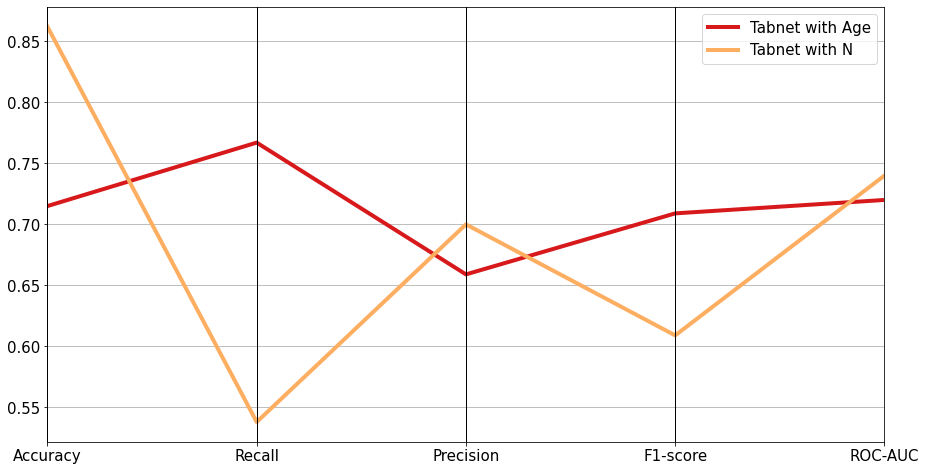

In [255]:
fig, ax = plt.subplots(figsize = (15, 8))
ax = pd.plotting.parallel_coordinates(merged_results3, 'Model', color=('#d7191c', '#fdae61', '#abdda4','#2b83ba'), linewidth = 4)
plt.legend(fontsize = 15)
ax.tick_params(axis = "both", which = "major", labelsize = 15)
#plt.savefig("merged_parallel.png")
plt.show()

## 1.5 Tabnet model validation on the supplementary dataset

### 1.5.1 Model on age, ldh, crp and limph

In [275]:
tab_preds3 = clf_tab.predict(X_china.to_numpy())
tab_score_merge3 = model_metrics(Y_china.to_numpy(), tab_preds3)

Confusion Matrix:
[[ 84 108]
 [  6 153]]
###################
Accuracy:  0.6752136752136753
Recall:  0.9622641509433962
Precision:  0.5862068965517241
F1:  0.7285714285714284
ROC-AUC:  0.6998820754716981


### 1.5.2 Model on ldh, crp, limph and n

In [260]:
tab_preds4 = clf_tab2.predict(X_china_n.to_numpy())
tab_score_merge4 = model_metrics(Y_china_n.to_numpy(), tab_preds4)

Confusion Matrix:
[[129  63]
 [ 37 122]]
###################
Accuracy:  0.7150997150997151
Recall:  0.7672955974842768
Precision:  0.6594594594594595
F1:  0.7093023255813954
ROC-AUC:  0.7195852987421384


### 1.5.3 Summary

In [261]:
merged_results4 = pd.DataFrame([np.around(tab_score_merge3, 3), np.around(tab_score_merged4, 3)], columns= ["Accuracy", "Recall", "Precision", "F1-score", "ROC-AUC"])
merged_results4["Model"] = ["Tabnet with Age", "Tabnet with N"]

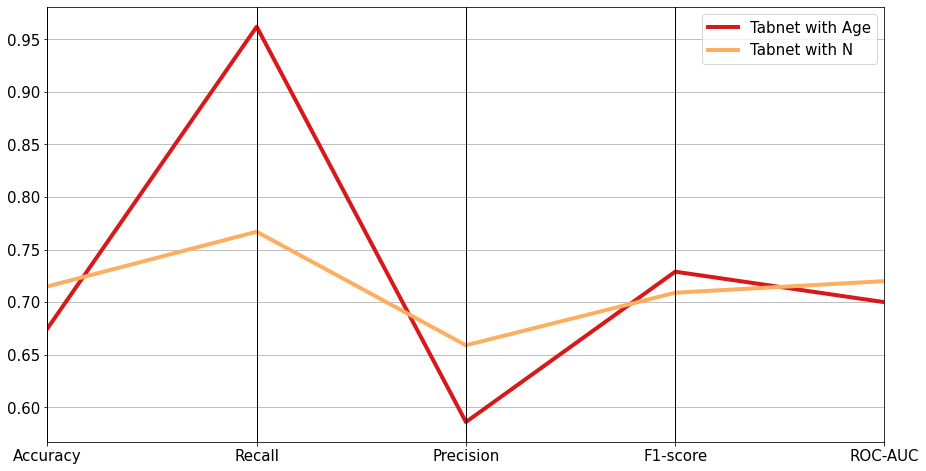

In [263]:
fig, ax = plt.subplots(figsize = (15, 8))
ax = pd.plotting.parallel_coordinates(merged_results4, 'Model', color=('#d7191c', '#fdae61', '#abdda4','#2b83ba'), linewidth = 4)
plt.legend(fontsize = 15)
ax.tick_params(axis = "both", which = "major", labelsize = 15)
#plt.savefig("merged_parallel.png")
plt.show()

# 2. Models from "An interpretable mortality prediction model for COVID-19 patients" article

## 2.1 Models without tendencies

### Data preparation

In [136]:
df_whole = pd.read_csv("Dane_merged.csv")
df_test = df_whole.sample(math.floor(len(df_whole) / 5))
df_train = df_whole.drop(df_test.index)

Y_train = df_train.outcome
X_train = df_train.drop("outcome", 1)

Y_test = df_test.outcome
X_test = df_test.drop("outcome", 1)

scaler = preprocessing.StandardScaler().fit(X_train)

X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

df_whole

,outcome,c_protein,lactate,lymphocyte
0,0.0,3.6,250.0,25.9
1,0.0,3.6,269.0,33.1
2,0.0,14.5,249.0,21.5
3,0.0,0.8,179.0,30.5
4,0.0,0.3,231.0,31.0
...,...,...,...,...
1436,0.0,4.1,301.0,8.0
1437,0.0,69.6,1126.0,14.2
1438,1.0,39.5,340.0,6.1
1439,1.0,73.3,491.0,21.9


### Logistic Regression

In [137]:
pipe = Pipeline([('classifier' , LogisticRegression())])

# Create param grid.

param_grid = [
    {'classifier' : [LogisticRegression()],
     'classifier__penalty' : ['l1', 'l2'],
    'classifier__C' : np.linspace(-2, 2, 100),
    'classifier__solver' : ['liblinear', 'lbfgs']}]

# Create grid search object

clf_log = model_selection.GridSearchCV(pipe, param_grid = param_grid, cv = 5, verbose=False,
                                       n_jobs=-1, scoring="f1")

# Fit on data

best_clf_log = clf_log.fit(X_train_scaled, Y_train)

In [138]:
log_preds = best_clf_log.predict(X_test_scaled)
log_prob = best_clf_log.predict_proba(X_test_scaled)


log_score_merged = model_metrics(Y_test, log_preds)

Confusion Matrix:
[[165  17]
 [ 38  68]]
###################
Accuracy:  0.8090277777777778
Recall:  0.6415094339622641
Precision:  0.8
F1:  0.7120418848167539
ROC-AUC:  0.7740514202778352


### Tabnet

In [139]:
df_train_v = df_train.sample(math.floor(len(df_train) / 10)) # Validation set will be 1/10 of training set
df_train_t = df_train.drop(df_train_v.index)

Y_train_t = df_train_t.outcome
X_train_t = df_train_t.drop("outcome", 1)

Y_train_v = df_train_v.outcome
X_train_v = df_train_v.drop("outcome", 1)

scaler = preprocessing.StandardScaler().fit(X_train_t)

X_train_t = scaler.transform(X_train_t)
X_train_v = scaler.transform(X_train_v)

from pytorch_tabnet.tab_model import TabNetClassifier

clf_tab = TabNetClassifier(seed = 123)
clf_tab.fit(X_train_t, Y_train_t, eval_set = [(X_train_v, Y_train_v)])
tab_preds = clf_tab.predict(X_test_scaled)

Device used : cpu
epoch 0  | loss: 0.60697 | val_0_auc: 0.70201 |  0:00:00s
epoch 1  | loss: 0.49441 | val_0_auc: 0.74879 |  0:00:00s
epoch 2  | loss: 0.49383 | val_0_auc: 0.74394 |  0:00:00s
epoch 3  | loss: 0.46471 | val_0_auc: 0.82744 |  0:00:00s
epoch 4  | loss: 0.46202 | val_0_auc: 0.84269 |  0:00:00s
epoch 5  | loss: 0.44531 | val_0_auc: 0.84685 |  0:00:00s
epoch 6  | loss: 0.47595 | val_0_auc: 0.85308 |  0:00:00s
epoch 7  | loss: 0.46647 | val_0_auc: 0.86348 |  0:00:00s
epoch 8  | loss: 0.4334  | val_0_auc: 0.84096 |  0:00:00s
epoch 9  | loss: 0.43996 | val_0_auc: 0.83714 |  0:00:00s
epoch 10 | loss: 0.45747 | val_0_auc: 0.83645 |  0:00:00s
epoch 11 | loss: 0.4789  | val_0_auc: 0.83264 |  0:00:00s
epoch 12 | loss: 0.43494 | val_0_auc: 0.83299 |  0:00:00s
epoch 13 | loss: 0.47007 | val_0_auc: 0.86001 |  0:00:00s
epoch 14 | loss: 0.44257 | val_0_auc: 0.86833 |  0:00:00s
epoch 15 | loss: 0.44617 | val_0_auc: 0.87283 |  0:00:01s
epoch 16 | loss: 0.45205 | val_0_auc: 0.88219 |  0:00:

In [140]:
tab_prob = clf_tab.predict_proba(X_test_scaled)

tab_score_merged = model_metrics(Y_test, tab_preds)

Confusion Matrix:
[[142  40]
 [ 23  83]]
###################
Accuracy:  0.78125
Recall:  0.7830188679245284
Precision:  0.6747967479674797
F1:  0.7248908296943231
ROC-AUC:  0.7816193240721543


### SVM

In [141]:
from sklearn import svm

# Create param grid.

param_grid = {'C': np.linspace(0.1, 2, 20), 'gamma': np.linspace(0.01, 1, 25),'kernel': ['rbf', 'poly', 'sigmoid']}

# Create grid search object

clf_svm = model_selection.GridSearchCV(svm.SVC(probability=True), param_grid = param_grid, cv = 5, verbose=False,
                                       n_jobs=-1, scoring="f1")

best_clf_svm = clf_svm.fit(X_train_scaled, Y_train)

In [142]:
svm_prob = clf_svm.predict_proba(X_test_scaled)
svm_preds = clf_svm.predict(X_test_scaled)

In [143]:
svm_score_merged = model_metrics(Y_test, svm_preds)

Confusion Matrix:
[[152  30]
 [ 37  69]]
###################
Accuracy:  0.7673611111111112
Recall:  0.6509433962264151
Precision:  0.696969696969697
F1:  0.6731707317073171
ROC-AUC:  0.7430541156956252


### Summary

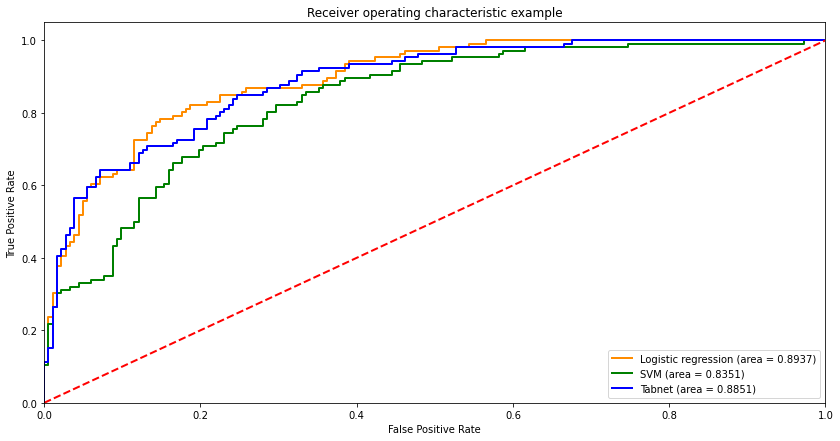

In [144]:
from sklearn.metrics import roc_curve, auc

fpr_log = dict()
tpr_log = dict()
roc_auc_log = dict()

fpr_log, tpr_log, thresholds_log = roc_curve(Y_test, log_prob[:,1], pos_label = 1)
roc_auc_log = auc(fpr_log, tpr_log)

fpr_svm = dict()
tpr_svm = dict()
roc_auc_svm = dict()

fpr_svm, tpr_svm, thresholds_tab = roc_curve(Y_test, svm_prob[:,1], pos_label = 1)
roc_auc_svm = auc(fpr_svm, tpr_svm)

fpr_tab = dict()
tpr_tab = dict()
roc_auc_tab = dict()

fpr_tab, tpr_tab, thresholds_tab = roc_curve(Y_test, tab_prob[:,1], pos_label = 1)
roc_auc_tab = auc(fpr_tab, tpr_tab)

fig, ax = plt.subplots(figsize = (14, 7))
lw = 2
plt.plot(fpr_log, tpr_log, color='darkorange',
         lw=lw, label='Logistic regression (area = %0.4f)' % roc_auc_log)
plt.plot(fpr_svm, tpr_svm, color='green',
         lw=lw, label='SVM (area = %0.4f)' % roc_auc_svm)
plt.plot(fpr_tab, tpr_tab, color='blue',
         lw=lw, label='Tabnet (area = %0.4f)' % roc_auc_tab)
plt.plot([0, 1], [0, 1], color='red', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
#plt.savefig("AUC_without.png")
plt.show()

## 2.2 Models with tendencies

<img src="AUC_with_tendencies.png" width="1200" height = "100">